После получения датасетов мы смогли:
- провести EDA с осмысленными визуализациями и качественным поиском первичных закономерностей;
- на основе проделенного EDA сформулировать **минимум три чёткие, содержательные гипотезы**;
- подобрать и реализовать  три различных статистических теста для проверки сформулированных раннее гипотез, причём каждый тест должен быть обязательно обоснован
- корректно и полно проинтерпретировать полученные результаты и сформулировать итоговые выводы.


## Введение

Представим, что мы в 2008 году. Нам поступил заказа на анализ данных о последовательности кликов в интернет-магазине, предлагающем одежду для беременных женщин.

Цель анализа - понять структуру спроса и сезонность, чтобы в будущем компания могла лучше планировать ассортимент, промо-активности и ценовую политику.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.api as sma
import statsmodels.formula.api as smfa
import statsmodels.tsa.stattools as smstt

## Предварительная обработка

In [ ]:
df=pd.read_csv("e-shop clothing 2008.csv", sep=';')
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165474 entries, 0 to 165473
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   year                     165474 non-null  int64 
 1   month                    165474 non-null  int64 
 2   day                      165474 non-null  int64 
 3   order                    165474 non-null  int64 
 4   country                  165474 non-null  int64 
 5   session ID               165474 non-null  int64 
 6   page 1 (main category)   165474 non-null  int64 
 7   page 2 (clothing model)  165474 non-null  object
 8   colour                   165474 non-null  int64 
 9   location                 165474 non-null  int64 
 10  model photography        165474 non-null  int64 
 11  price                    165474 non-null  int64 
 12  price 2                  165474 non-null  int64 
 13  page                     165474 non-null  int64 
dtypes: int64(13), object

,0
year,0
month,0
day,0
order,0
country,0
session ID,0
page 1 (main category),0
page 2 (clothing model),0
colour,0
location,0


In [ ]:
df

,year,month,day,order,country,session ID,page 1 (main category),page 2 (clothing model),colour,location,model photography,price,price 2,page
0,2008,4,1,1,29,1,1,A13,1,5,1,28,2,1
1,2008,4,1,2,29,1,1,A16,1,6,1,33,2,1
2,2008,4,1,3,29,1,2,B4,10,2,1,52,1,1
3,2008,4,1,4,29,1,2,B17,6,6,2,38,2,1
4,2008,4,1,5,29,1,2,B8,4,3,2,52,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165469,2008,8,13,1,29,24024,2,B10,2,4,1,67,1,1
165470,2008,8,13,1,9,24025,1,A11,3,4,1,62,1,1
165471,2008,8,13,1,34,24026,1,A2,3,1,1,43,2,1
165472,2008,8,13,2,34,24026,3,C2,12,1,1,43,1,1


### Очистка данных

In [ ]:
dup_all = df.duplicated().sum()
dup_all

np.int64(0)

In [ ]:
main_cat_map = {
    1: "trousers",
    2: "skirts",
    3: "blouses",
    4: "sale"}
df["main_category"] = df["page 1 (main category)"].map(main_cat_map)

colour_map = {
    1:"beige",
    2:"black",
    3:"blue",
    4:"brown",
    5:"burgundy",
    6:"gray",
    7:"green",
    8:"navy blue",
    9:"of many colors",
    10:"olive",
    11:"pink",
    12:"red",
    13:"violet",
    14:"white"}
df["colour_name"] = df["colour"].map(colour_map)

location_map = {
    1:"top left",
    2:"top middle",
    3:"top right",
    4:"bottom left",
    5:"bottom middle",
    6:"bottom right"}
df["location_name"] = df["location"].map(location_map)

photo_map = {
    1:"en face",
    2:"profile"}
df["photo_type"] = df["model photography"].map(photo_map)

In [ ]:
df['page 1 (main category)'] = df['page 1 (main category)'].astype('category')
df['colour'] = df['colour'].astype('category')
df['location'] = df['location'].astype('category')
df['model photography'] = df['model photography'].astype('category')

df['main_category'] = df['main_category'].astype('category')
df['colour_name'] = df['colour_name'].astype('category')
df['location_name'] = df['location_name'].astype('category')
df['photo_type'] = df['photo_type'].astype('category')
df['price'] = pd.to_numeric(df['price'], errors='coerce')

In [ ]:
user_stats = df.groupby('country')['session ID'].nunique().reset_index()
user_stats.columns = ['country', 'user_count']

user_stats = user_stats.sort_values(by='user_count', ascending=False)

print(user_stats)

    country  user_count
28       29       19582
8         9        2261
45       46         681
23       24         527
43       44         240
40       41         127
20       21         102
15       16         101
33       34          88
11       12          28
26       27          26
41       42          26
37       38          25
9        10          23
27       28          21
2         3          20
14       15          18
21       22          16
36       37          15
1         2          11
30       31          10
10       11           9
31       32           9
13       14           7
38       39           6
24       25           5
18       19           5
16       17           5
42       43           4
46       47           3
35       36           3
44       45           2
29       30           2
19       20           2
22       23           2
6         7           2
17       18           2
0         1           1
3         4           1
12       13           1
7         8     

In [ ]:
user_stats = df.groupby('page 1 (main category)')['session ID'].nunique().reset_index()
user_stats.columns = ['page 1 (main category)', 'user_count']

user_stats = user_stats.sort_values(by='user_count', ascending=False)

print(user_stats)

  page 1 (main category)  user_count
0                      1       13082
1                      2       11490
2                      3       10724
3                      4        9192


/tmp/ipython-input-1243525375.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  user_stats = df.groupby('page 1 (main category)')['session ID'].nunique().reset_index()


In [ ]:
user_stats = df.groupby('colour')['session ID'].nunique().reset_index()
user_stats.columns = ['colour', 'user_count']

user_stats = user_stats.sort_values(by='user_count', ascending=False)

print(user_stats)

   colour  user_count
1       2       11968
2       3       10945
5       6        8986
3       4        8512
13     14        7878
8       9        7096
11     12        5964
6       7        4664
0       1        4634
12     13        4224
10     11        3920
9      10        3212
7       8        2440
4       5        1315


/tmp/ipython-input-990006148.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  user_stats = df.groupby('colour')['session ID'].nunique().reset_index()


In [ ]:
user_stats = df.groupby('order')['session ID'].nunique().reset_index()
user_stats.columns = ['order', 'user_count']

user_stats = user_stats.sort_values(by='user_count', ascending=False)
print(user_stats)

     order  user_count
0        1       24026
1        2       18984
2        3       15664
3        4       13044
4        5       11007
..     ...         ...
190    191           2
191    192           2
192    193           1
193    194           1
194    195           1

[195 rows x 2 columns]


Почти все пользователи - из Польши, есть ещё заметные группы из Чехии и Литвы. Остальные же совсем незначимы. Для простоты анализа и чтобы исключить разницу в поведении пользователей из разных стран оставим в рассмотрении только Польшу.

In [ ]:
df = df[df['country'] == 29]
del df['country']
df

,year,month,day,order,session ID,page 1 (main category),page 2 (clothing model),colour,location,model photography,price,price 2,page,main_category,colour_name,location_name,photo_type
0,2008,4,1,1,1,1,A13,1,5,1,28,2,1,trousers,beige,bottom middle,en face
1,2008,4,1,2,1,1,A16,1,6,1,33,2,1,trousers,beige,bottom right,en face
2,2008,4,1,3,1,2,B4,10,2,1,52,1,1,skirts,olive,top middle,en face
3,2008,4,1,4,1,2,B17,6,6,2,38,2,1,skirts,gray,bottom right,profile
4,2008,4,1,5,1,2,B8,4,3,2,52,1,1,skirts,brown,top right,profile
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165465,2008,8,13,4,24023,1,A16,1,6,1,33,2,1,trousers,beige,bottom right,en face
165466,2008,8,13,5,24023,4,P11,4,4,2,38,1,1,sale,brown,bottom left,profile
165467,2008,8,13,6,24023,4,P18,2,6,1,28,2,1,sale,black,bottom right,en face
165468,2008,8,13,7,24023,4,P13,4,5,1,38,1,1,sale,brown,bottom middle,en face


In [ ]:
len(df)

133963

In [ ]:
df = df.drop(columns=['page 1 (main category)', 'colour', 'model photography', 'location'])

In [ ]:
df = df.rename(columns={'page 2 (clothing model)': 'clothing model'})

In [ ]:
df = df[['year', 'month', 'day', 'session ID', 'order', 'page', 'main_category',
         'clothing model', 'price', 'colour_name', 'location_name', 'photo_type', 'price 2']]

In [ ]:
df

,year,month,day,session ID,order,page,main_category,clothing model,price,colour_name,location_name,photo_type,price 2
0,2008,4,1,1,1,1,trousers,A13,28,beige,bottom middle,en face,2
1,2008,4,1,1,2,1,trousers,A16,33,beige,bottom right,en face,2
2,2008,4,1,1,3,1,skirts,B4,52,olive,top middle,en face,1
3,2008,4,1,1,4,1,skirts,B17,38,gray,bottom right,profile,2
4,2008,4,1,1,5,1,skirts,B8,52,brown,top right,profile,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
165465,2008,8,13,24023,4,1,trousers,A16,33,beige,bottom right,en face,2
165466,2008,8,13,24023,5,1,sale,P11,38,brown,bottom left,profile,1
165467,2008,8,13,24023,6,1,sale,P18,28,black,bottom right,en face,2
165468,2008,8,13,24023,7,1,sale,P13,38,brown,bottom middle,en face,1


In [ ]:
df['date'] = pd.to_datetime(dict(year=df['year'], month=df['month'], day=df['day']))
df = df.sort_values('date').reset_index(drop=True)

print(df['date'].min())
print(df['date'].max())

2008-04-01 00:00:00
2008-08-13 00:00:00


In [ ]:
df.duplicated(subset=['session ID', 'order']).sum()

np.int64(0)

Видим, что анализ проводился с 1 апреля до 13 августа 2008 года

In [ ]:
product_by_category = df.groupby('main_category')['clothing model'].unique()

categories = list(product_by_category.index)

for i in range(len(categories)):
    for j in range(i + 1, len(categories)):
        cat1, cat2 = categories[i], categories[j]
        common = set(product_by_category[cat1]).intersection(product_by_category[cat2])
        if common:
            print(f"Пересечение: {cat1} и {cat2}")
            print(f"Общие товары ({len(common)}): {list(common)[:10]}")

Пересечение: skirts и trousers
Общие товары (1): ['A18']


/tmp/ipython-input-393695351.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  product_by_category = df.groupby('main_category')['clothing model'].unique()


In [ ]:
df = df[df['clothing model'] != 'A18']

In [ ]:
df = df.drop(columns=['year'])

In [ ]:
df = df[['date', 'month', 'day', 'session ID', 'order', 'page', 'main_category',
         'clothing model', 'price', 'colour_name', 'location_name', 'photo_type', 'price 2']]

## Аналитика

### Цена

Посмотрим на распределение кликов по цене.

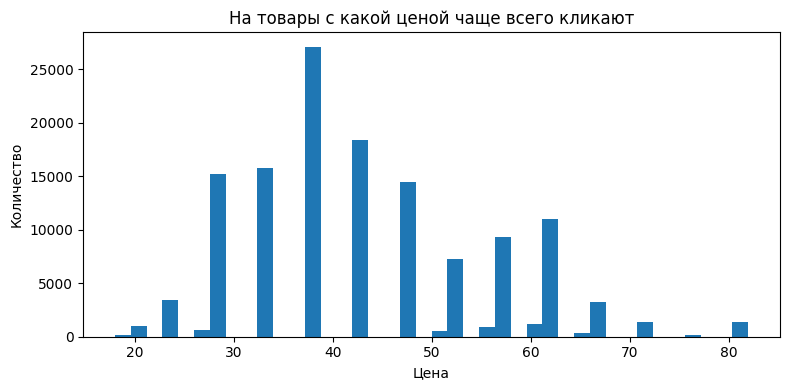

In [ ]:
plt.figure(figsize=(8,4))
plt.hist(df['price'], bins=40)
plt.xlabel('Цена')
plt.ylabel('Количество')
plt.title('На товары с какой ценой чаще всего кликают')
plt.tight_layout()
plt.show()

Можно выделить два пика - в районе 40 и 60 долларов, между ними есть очевидная просадка. Можно предположить, что это две психологические отметки, где 40 - "нормальная" цена для среднего сегмента по мнению покупателей, а 60 - "нормальная" цена для товара более высокого качества.

### Категории

Количество кликов по каждой из категорий.

  main_category  clicks
0      trousers   36434
1          sale   36084
2        skirts   31122
3       blouses   29611


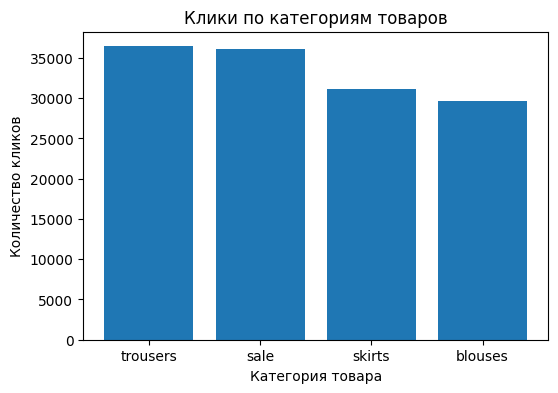

In [ ]:
clicks = df['main_category'].value_counts().reset_index(name='clicks')
clicks.columns = ['main_category', 'clicks']

print(clicks)

plt.figure(figsize=(6,4))
plt.bar(clicks['main_category'], clicks['clicks'])
plt.xlabel('Категория товара')
plt.ylabel('Количество кликов')
plt.title('Клики по категориям товаров')
plt.show()

Больше всего кликают на "Брюки" и "Скидки", однако сильного разрыва нет.

Теперь посмотрим распределение цены по категориям.

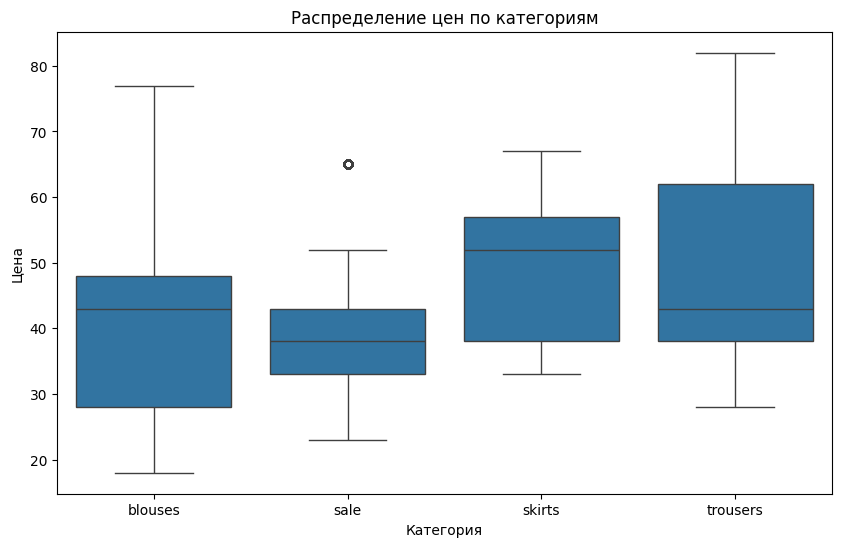

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='main_category', y='price')
plt.title('Распределение цен по категориям')
plt.xlabel('Категория')
plt.ylabel('Цена')
plt.show()

"Скидки" имеют наименьшее отклонение от среднего, при этом оно же равноудалено от первого и третьего квартиля. Также можно отметить сильный сдвиг в стороны квартилей у трёх других категорий, что говорит о неравномерности распределений цен внутри категорий.

In [ ]:
products_by_category = df.groupby('main_category')['clothing model'].unique()
print(products_by_category)

main_category
blouses     [C36, C48, C21, C45, C17, C33, C32, C14, C9, C...
sale        [P3, P5, P9, P7, P13, P50, P15, P6, P14, P8, P...
skirts      [B17, B16, B33, B11, B1, B34, B22, B31, B4, B2...
trousers    [A13, A4, A42, A11, A15, A31, A33, A26, A35, A...
Name: clothing model, dtype: object


/tmp/ipython-input-444215366.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  products_by_category = df.groupby('main_category')['clothing model'].unique()


Кодировка товаров напрямую взаимосвязана с категориями: C - blouses, P - sale, B - skirts, A - trousers.

In [ ]:
df = df.copy()
df['date'] = pd.to_datetime(df['date'])

df['year_month'] = df['date'].dt.to_period('M').astype(str)

In [ ]:
clicks_cat_month = (df.groupby(['year_month', 'main_category']).size().reset_index(name='clicks'))

/tmp/ipython-input-3396897990.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  clicks_cat_month = (df.groupby(['year_month', 'main_category']).size().reset_index(name='clicks'))


In [ ]:
clicks_cat_month['share'] = (clicks_cat_month['clicks'] /clicks_cat_month.groupby('year_month')['clicks'].transform('sum'))

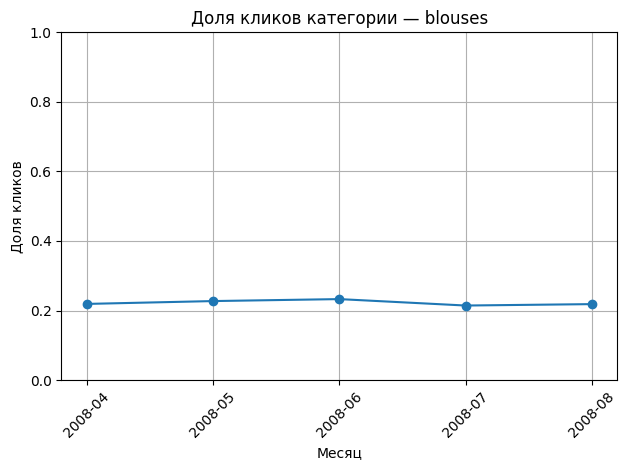

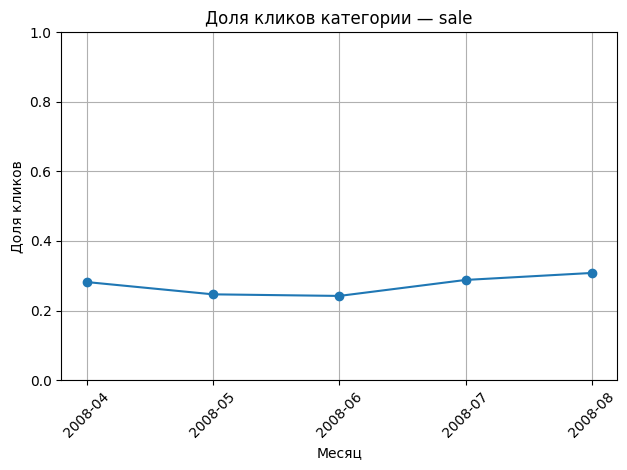

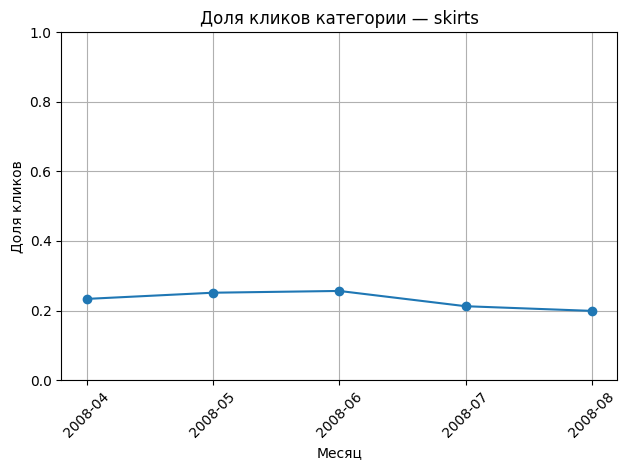

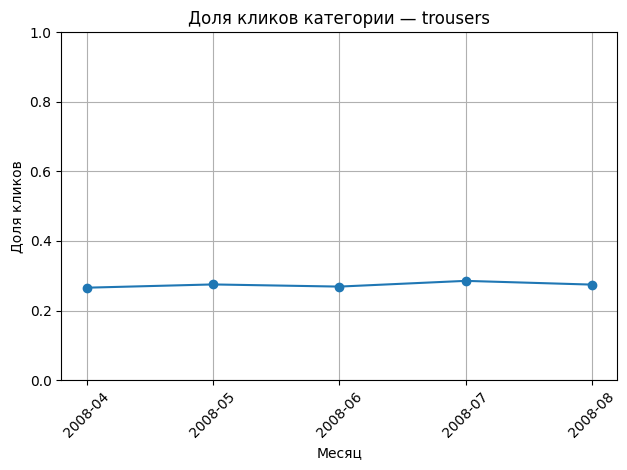

In [ ]:
categories = clicks_cat_month['main_category'].unique()

for cat in categories:
    data_cat = clicks_cat_month[
        clicks_cat_month['main_category'] == cat
    ].sort_values('year_month')

    plt.figure()
    plt.plot(
        data_cat['year_month'],
        data_cat['share'],
        marker='o'
    )

    plt.title(f'Доля кликов категории — {cat}')
    plt.xlabel('Месяц')
    plt.ylabel('Доля кликов')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Товары

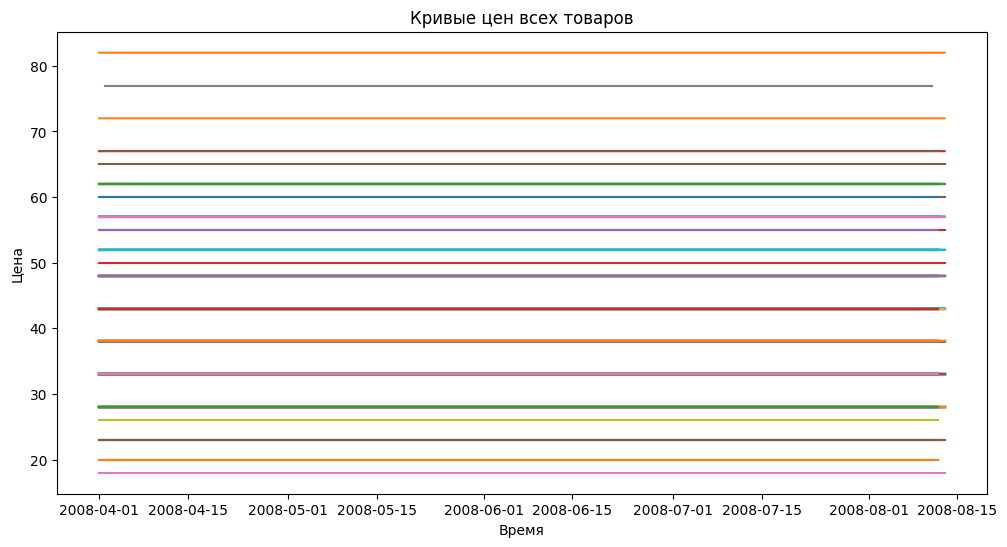

In [ ]:
plt.figure(figsize=(12,6))

for product, group in df.groupby('clothing model'):
    plt.plot(group['date'], group['price'])

plt.xlabel('Время')
plt.ylabel('Цена')
plt.title('Кривые цен всех товаров')
plt.show()

Цены на протяжении всего периода сбора данных не менялись.

In [ ]:
df

,date,month,day,session ID,order,page,main_category,clothing model,price,colour_name,location_name,photo_type,price 2,year_month
0,2008-04-01,4,1,1,1,1,trousers,A13,28,beige,bottom middle,en face,2,2008-04
1,2008-04-01,4,1,292,41,2,blouses,C36,43,white,bottom right,en face,1,2008-04
2,2008-04-01,4,1,292,42,3,blouses,C48,28,gray,bottom left,en face,2,2008-04
3,2008-04-01,4,1,292,43,1,trousers,A4,38,blue,top middle,profile,2,2008-04
4,2008-04-01,4,1,292,44,2,blouses,C21,57,white,top left,en face,1,2008-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133958,2008-08-13,8,13,24012,17,3,blouses,C47,18,violet,bottom left,profile,2,2008-08
133959,2008-08-13,8,13,24012,18,3,blouses,C53,38,white,bottom right,en face,2,2008-08
133960,2008-08-13,8,13,24012,19,3,blouses,C53,38,white,bottom right,en face,2,2008-08
133961,2008-08-13,8,13,24011,8,2,blouses,C19,48,red,top left,en face,1,2008-08


In [ ]:
top_products = (df.groupby('clothing model').size().sort_values(ascending=False))
top_products.head(10)

,0
clothing model,
B4,2940
P1,2521
A2,2257
B10,2163
A11,2134
A4,1997
A15,1996
A1,1776
A10,1650


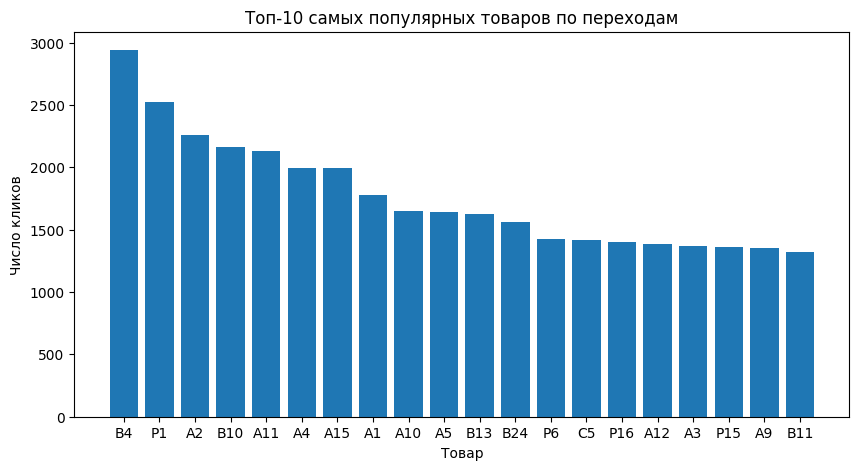

In [ ]:
top_10 = top_products.head(20)

plt.figure(figsize=(10, 5))
plt.bar(top_10.index, top_10.values)
plt.xlabel('Товар')
plt.ylabel('Число кликов')
plt.title('Топ-10 самых популярных товаров по переходам')
plt.show()

### Время

Количество кликов по дням недели и месяцам.

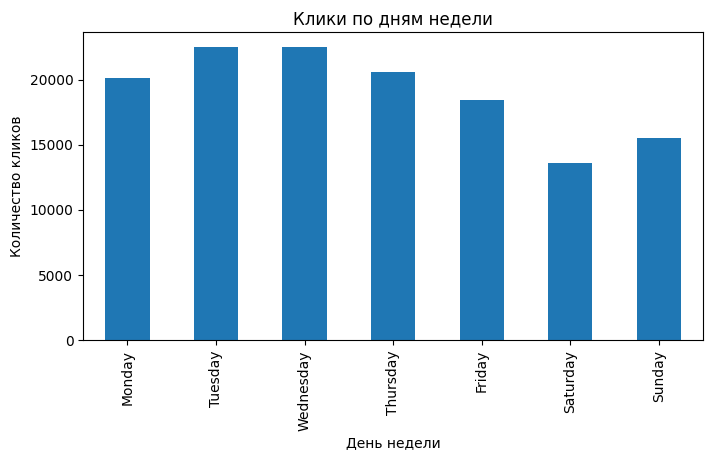

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df['weekday_name'] = df['date'].dt.day_name()

clicks_by_weekday = df.groupby('weekday_name').size()

weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
clicks_by_weekday = clicks_by_weekday.reindex(weekday_order)

plt.figure(figsize=(8, 4))
clicks_by_weekday.plot(kind='bar', legend=False)
plt.xlabel('День недели')
plt.ylabel('Количество кликов')
plt.title('Клики по дням недели')
plt.show()

Пик активности приходится на середину недели, падая до минимума на выходных, а дальше снова начинается рост.

#### Гипотеза 1: Среднее число кликов в середине недели выше, чем на выходных

Нулевая гипотеза: Среднее число кликов в середине недели равно среднему числу кликов на выходных.

Альтернативная гипотеза: Среднее число кликов в середине недели выше, чем на выходных.

In [ ]:
daily_clicks = df.groupby('date').size().reset_index(name='clicks')
daily_clicks['weekday_name'] = daily_clicks['date'].dt.day_name()

mid_week_clicks = daily_clicks[daily_clicks['weekday_name'].isin(['Monday','Tuesday','Wednesday','Thursday','Friday'])]['clicks']
weekend_clicks = daily_clicks[daily_clicks['weekday_name'].isin(['Saturday','Sunday'])]['clicks']

print(len(mid_week_clicks))
print(len(weekend_clicks))

97
38


Для определения правильного теста проведём проверку на нормальность с помощью теста Шапиро-Уилка. Условие его применимости - нужных размеров выборки (3 < n < 5000), и их неавзисимость. Последнее условие выполнено, размеры тоже соответствуют ограничениям (97 и 38).

In [ ]:
from scipy.stats import shapiro

print(shapiro(mid_week_clicks))
print(shapiro(weekend_clicks))

ShapiroResult(statistic=np.float64(0.7896789020149929), pvalue=np.float64(1.8589555562255766e-10))
ShapiroResult(statistic=np.float64(0.9385687752182407), pvalue=np.float64(0.03765400688989052))


По Шапиро-Уилку p-value < 0.05, значит, данные не нормальные и мы не можем применять t-тест. Следующий вариант - тест Манна-Уитни. Для него необходимы независимые выборки, достаточные размеры (n > 10), одинаковая форма данных в обеих выборках. Все условия выполняются, значит, можем применять тест Манна-Уитни. Для того, чтобы определить не только сам факт различия, но и то, правда ли в первой выборке среднее число кликов именно выше, указываем в параметрах alternative='greater'.

In [ ]:
from scipy.stats import mannwhitneyu

print(mannwhitneyu(mid_week_clicks, weekend_clicks, alternative='greater'))

MannwhitneyuResult(statistic=np.float64(3108.0), pvalue=np.float64(3.06842985368493e-10))


По Манна-Уитни p-value < 0.05, значит, отвергаем нулевую гипотезу и принимаем альтернативную гипотезу: Среднее число кликов в середине недели выше, чем на выходных.

/tmp/ipython-input-3321163266.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1279.3333333333333' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  clicks_per_day[month] = clicks_per_day[month] / days_in_month[month]


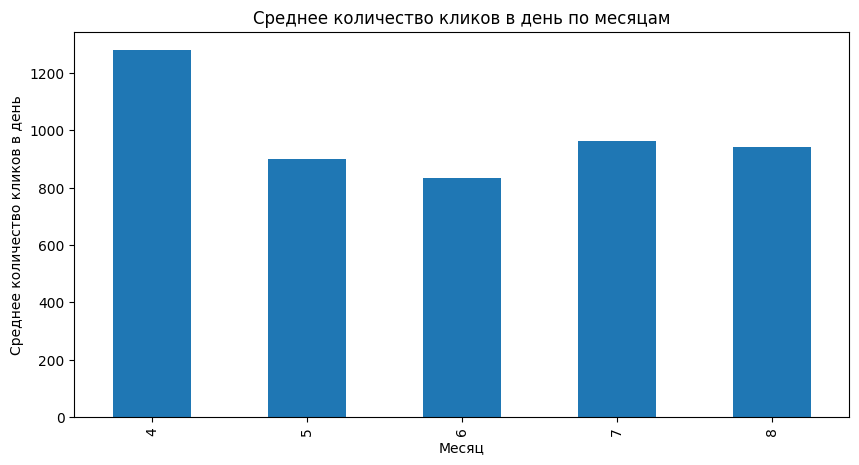

In [ ]:
clicks_by_month = df.groupby('month').size()

days_in_month = {
    4: 30,
    5: 31,
    6: 30,
    7: 31,
    8: 13,
}

clicks_per_day = clicks_by_month.copy()
for month in clicks_per_day.index:
    if month in days_in_month:
        clicks_per_day[month] = clicks_per_day[month] / days_in_month[month]

plt.figure(figsize=(10, 5))
clicks_per_day.plot(kind='bar')
plt.xlabel('Месяц')
plt.ylabel('Среднее количество кликов в день')
plt.title('Среднее количество кликов в день по месяцам')
plt.show()

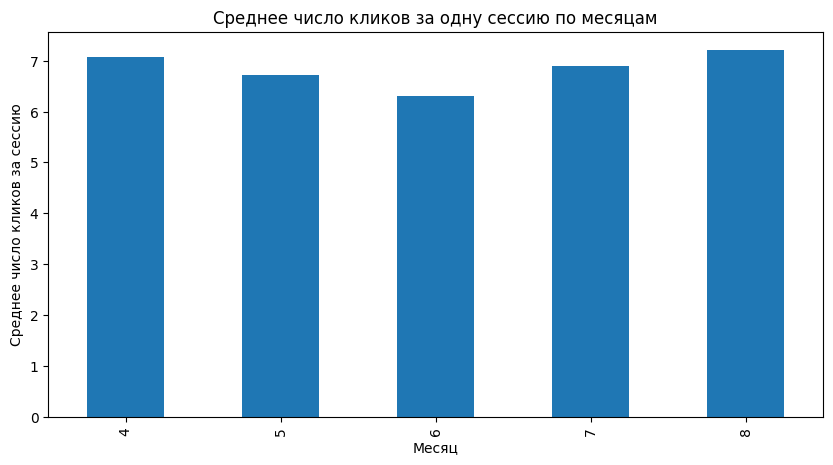

In [ ]:
clicks_per_session = (df.groupby(['month', 'session ID']).size())

avg_clicks_per_session_by_month = (clicks_per_session.groupby('month').mean())

plt.figure(figsize=(10, 5))
avg_clicks_per_session_by_month.plot(kind='bar')
plt.xlabel('Месяц')
plt.ylabel('Среднее число кликов за сессию')
plt.title('Среднее число кликов за одну сессию по месяцам')
plt.show()

В случае с месяцами выделяется падение активности с приближением лета, однако уже в июле значения стали отрастать. Причём это касается не только среднего числа кликов по месяцам на всём сайте, но и среднего числа кликов для каждой сессии.

Так как датасет обрезается на 13 августа (не включительно), рассматриваем только доступную нам часть месяца.

In [ ]:
df

,date,month,day,session ID,order,page,main_category,clothing model,price,colour_name,location_name,photo_type,price 2,year_month,weekday_name
0,2008-04-01,4,1,1,1,1,trousers,A13,28,beige,bottom middle,en face,2,2008-04,Tuesday
1,2008-04-01,4,1,292,41,2,blouses,C36,43,white,bottom right,en face,1,2008-04,Tuesday
2,2008-04-01,4,1,292,42,3,blouses,C48,28,gray,bottom left,en face,2,2008-04,Tuesday
3,2008-04-01,4,1,292,43,1,trousers,A4,38,blue,top middle,profile,2,2008-04,Tuesday
4,2008-04-01,4,1,292,44,2,blouses,C21,57,white,top left,en face,1,2008-04,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133958,2008-08-13,8,13,24012,17,3,blouses,C47,18,violet,bottom left,profile,2,2008-08,Wednesday
133959,2008-08-13,8,13,24012,18,3,blouses,C53,38,white,bottom right,en face,2,2008-08,Wednesday
133960,2008-08-13,8,13,24012,19,3,blouses,C53,38,white,bottom right,en face,2,2008-08,Wednesday
133961,2008-08-13,8,13,24011,8,2,blouses,C19,48,red,top left,en face,1,2008-08,Wednesday


### Сессии

In [ ]:
df

,date,month,day,session ID,order,page,main_category,clothing model,price,colour_name,location_name,photo_type,price 2,year_month,weekday_name
0,2008-04-01,4,1,1,1,1,trousers,A13,28,beige,bottom middle,en face,2,2008-04,Tuesday
1,2008-04-01,4,1,292,41,2,blouses,C36,43,white,bottom right,en face,1,2008-04,Tuesday
2,2008-04-01,4,1,292,42,3,blouses,C48,28,gray,bottom left,en face,2,2008-04,Tuesday
3,2008-04-01,4,1,292,43,1,trousers,A4,38,blue,top middle,profile,2,2008-04,Tuesday
4,2008-04-01,4,1,292,44,2,blouses,C21,57,white,top left,en face,1,2008-04,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133958,2008-08-13,8,13,24012,17,3,blouses,C47,18,violet,bottom left,profile,2,2008-08,Wednesday
133959,2008-08-13,8,13,24012,18,3,blouses,C53,38,white,bottom right,en face,2,2008-08,Wednesday
133960,2008-08-13,8,13,24012,19,3,blouses,C53,38,white,bottom right,en face,2,2008-08,Wednesday
133961,2008-08-13,8,13,24011,8,2,blouses,C19,48,red,top left,en face,1,2008-08,Wednesday


In [ ]:
session_features = (
    df.groupby('session ID')
      .agg(
          n_items=('order', 'max'),
          n_main_cat=('main_category', 'nunique'),
          n_colour=('colour_name', 'nunique'),
          n_location=('location_name', 'nunique'),
          expensive=("price 2", lambda x: (x == 1).mean())
      )
)

session_features

,n_items,n_main_cat,n_colour,n_location,expensive
session ID,,,,,
1,9,4,6,6,0.555556
2,10,3,5,6,0.800000
7,11,4,7,4,0.363636
9,3,2,2,2,0.500000
12,7,3,6,5,0.857143
...,...,...,...,...,...
24020,5,2,3,4,0.800000
24021,5,2,3,4,0.400000
24022,3,1,3,2,0.000000


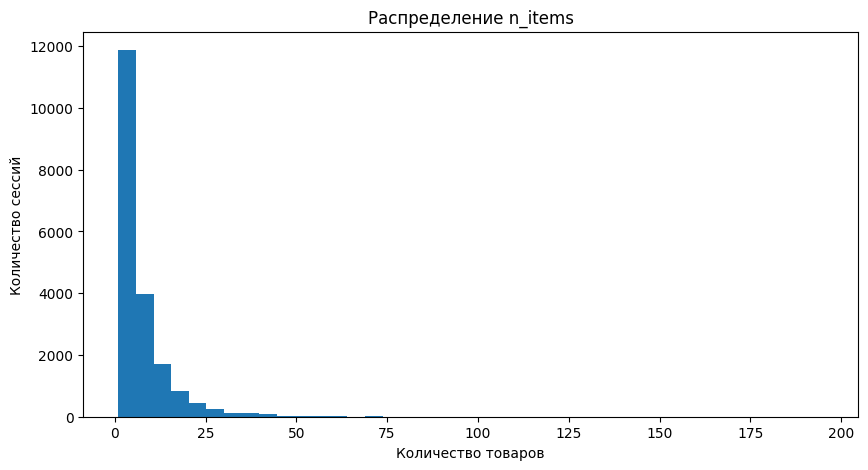

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(session_features['n_items'], bins=40)
plt.xlabel('Количество товаров')
plt.ylabel('Количество сессий')
plt.title('Распределение n_items')
plt.show()

In [ ]:
print(session_features['n_main_cat'].describe())

count    19558.000000
mean         1.872175
std          0.971613
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: n_main_cat, dtype: float64


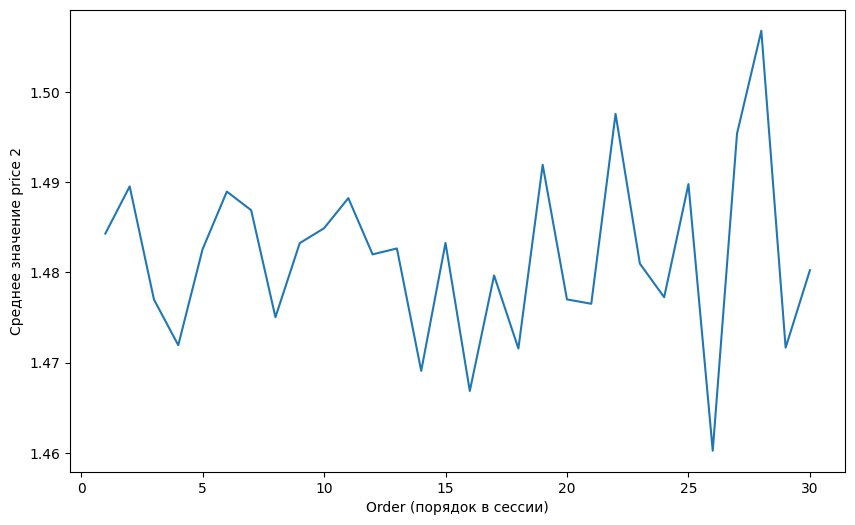

In [ ]:
price2_by_order = df[df['order'] <= 30].groupby('order')['price 2'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(price2_by_order['order'], price2_by_order['price 2'])
plt.xlabel('Order (порядок в сессии)')
plt.ylabel('Среднее значение price 2')
plt.show()

### Расположение

Для наглядности отобразим расположение картинок в сетке

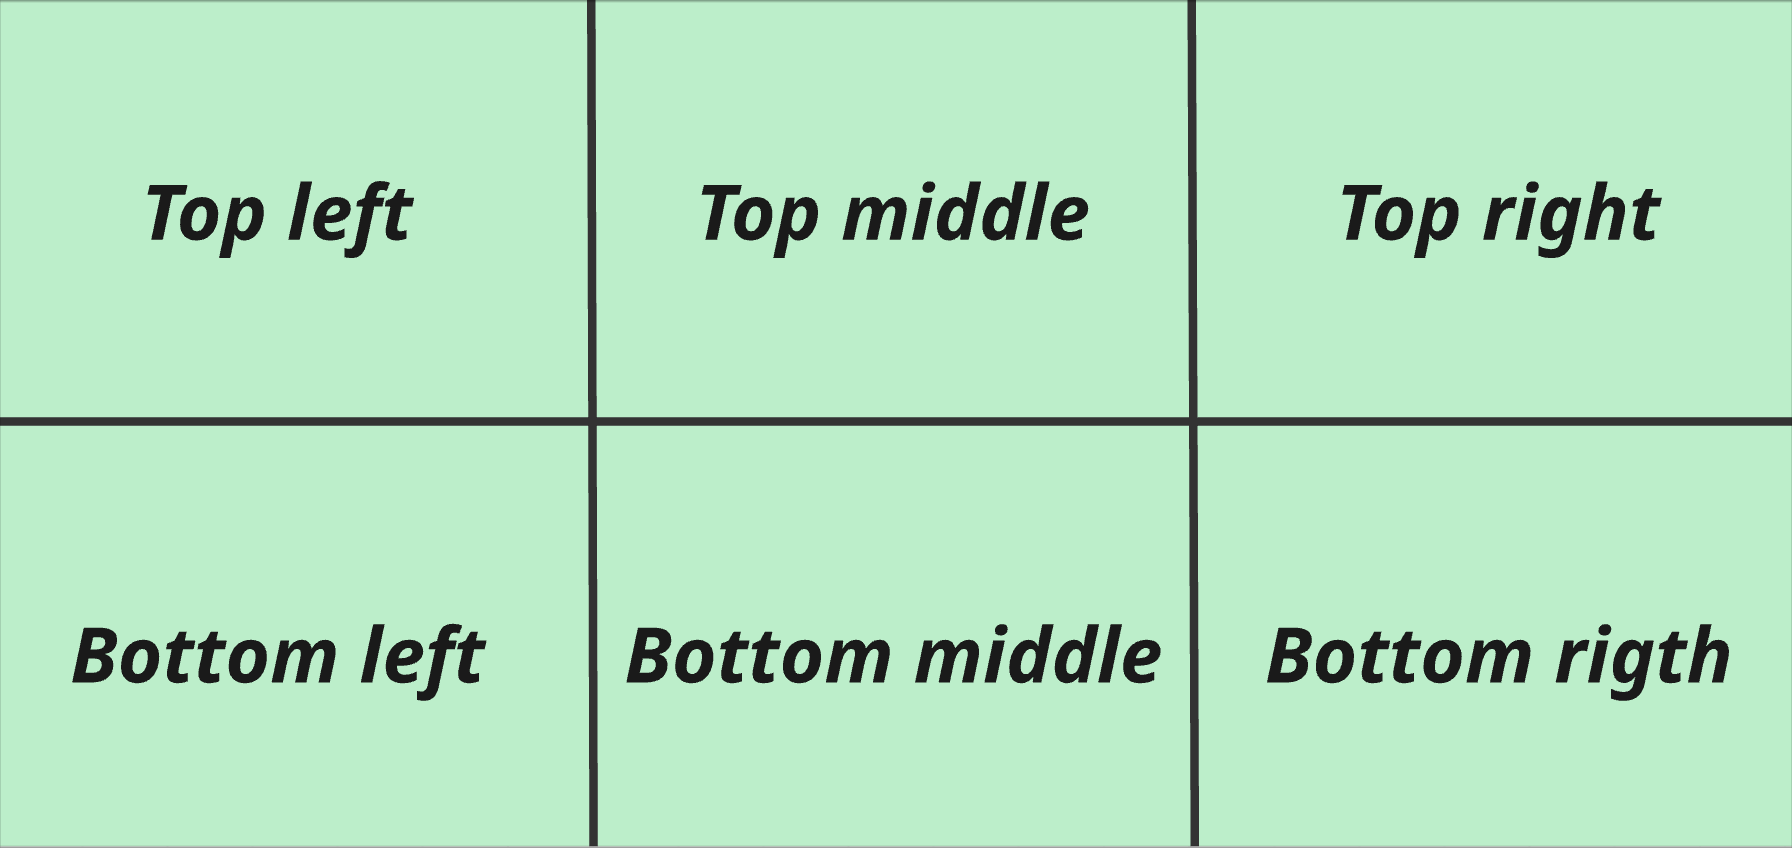

Количество кликов по каждому расположению карточки товара

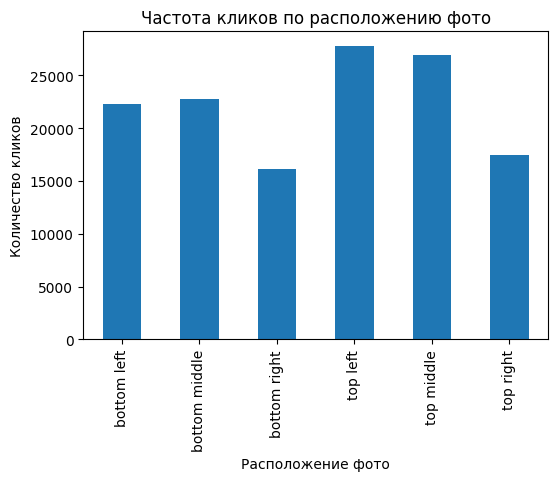

In [ ]:
counts = df['location_name'].value_counts().sort_index()

plt.figure(figsize=(6,4))
ax = counts.plot(kind='bar')

ax.set_xlabel('Расположение фото')
ax.set_ylabel('Количество кликов')
ax.set_title('Частота кликов по расположению фото')
plt.show()

Найдём, каким по порядку в среднем нажимают на каждый из блоков. Важно - чтобы повторы внутри сессии не сбивали выборку, будем учитывать только первое нажатие в каждой выборке

In [ ]:
first_location_clicks = df.groupby(['session ID', 'location_name'])['order'].min().reset_index()

location_avg_order = first_location_clicks.groupby('location_name')['order'].agg([
    'count',
    'mean',
    'std',
    'min',
    'median'
]).round(2)

location_avg_order = location_avg_order.sort_values('mean')

print("Средний порядок первого нажатия для каждого расположения")
print(location_avg_order)

Средний порядок первого нажатия для каждого расположения
               count  mean   std  min  median
location_name                                
top left       11223  2.81  2.66  1.0     2.0
top middle     11512  3.11  2.70  1.0     2.0
bottom left    10271  3.47  3.17  1.0     2.0
bottom middle  10504  3.52  3.38  1.0     2.0
top right       8515  4.17  3.63  1.0     3.0
bottom right    8231  4.39  4.25  1.0     3.0


/tmp/ipython-input-2763969738.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  first_location_clicks = df.groupby(['session ID', 'location_name'])['order'].min().reset_index()
/tmp/ipython-input-2763969738.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  location_avg_order = first_location_clicks.groupby('location_name')['order'].agg([


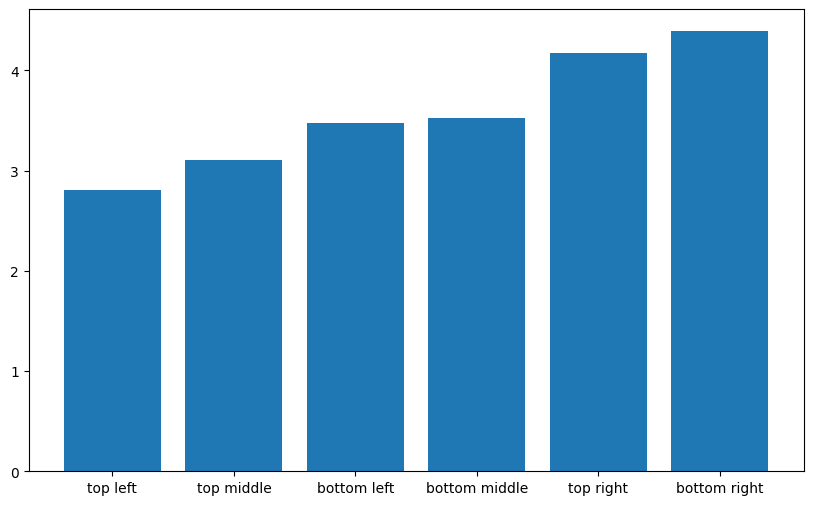

In [ ]:
plt.figure(figsize=(10, 6))
bars = plt.bar(location_avg_order.index, location_avg_order["mean"])

#### Гипотеза 2: Чем выше и левее находится блок, тем раньше на него кликают.

Для начала проверим, есть ли вообще разница между шестью блоками.

Нулевая гипотеза: Распределение порядка первого клика одинаково для верхних и нижних блоков.

Альтернативная гипотеза: Первые клики чаще уходят верхним блокам.

В данном случае t-тест точно не подходит, так как данные дискретные, а не непрерывные. Перейдём сразу к варианту с тестом Манна-Уитни. Наши выборки не прямо полностью независимы, но так как зависимости одинаково влияют на каждую из групп, можем сделать это допущение. Достаточные размеры выборок. Условия для Манна-Уитни выполнены

In [ ]:
first_location_clicks = (df.groupby(['session ID', 'location_name'])['order'].min().reset_index())

top_blocks = ['top left', 'top middle', 'top right']
bottom_blocks = ['bottom left', 'bottom middle', 'bottom right']

top = (first_location_clicks.loc[first_location_clicks['location_name'].isin(top_blocks), 'order'].dropna())

bottom = (first_location_clicks.loc[first_location_clicks['location_name'].isin(bottom_blocks), 'order'].dropna())

/tmp/ipython-input-3209156476.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  first_location_clicks = (df.groupby(['session ID', 'location_name'])['order'].min().reset_index())


In [ ]:
from scipy.stats import mannwhitneyu

print(mannwhitneyu(top, bottom, alternative='less'))

MannwhitneyuResult(statistic=np.float64(420359935.0), pvalue=np.float64(3.0728776649552877e-56))


По итогу проведения тестирования p-value < 0.05, значит, отвергаем нулевую гипотезу и можем считать, что первые клики чаще уходят верхним блокам.

Теперь с аналогичными вводными проведём тестирования для сравнения левых и средних блоков и средних и правых блоков.

Нулевая гипотеза: Распределение порядка первого клика одинаково для левых и средних блоков/средних и правых блоков

Альтернативная гипотеза: Первые клики чаще уходят левым/средним блокам.

In [ ]:
left_blocks = ['top left', 'bottom left']
middle_blocks = ['top middle', 'bottom middle']

left = (first_location_clicks.loc[first_location_clicks['location_name'].isin(left_blocks), 'order'].dropna())

middle = (first_location_clicks.loc[first_location_clicks['location_name'].isin(middle_blocks), 'order'].dropna())

In [ ]:
print(mannwhitneyu(left, middle, alternative='less'))

MannwhitneyuResult(statistic=np.float64(225566386.0), pvalue=np.float64(2.147413147945436e-18))


По итогу проведения тестирования p-value < 0.05, значит, отвергаем нулевую гипотезу и можем считать, что первые клики чаще уходят левым блокам, чем средним.

In [ ]:
middle_blocks = ['top middle', 'bottom middle']
right_blocks = ['top right', 'bottom right']

middle = (first_location_clicks.loc[first_location_clicks['location_name'].isin(middle_blocks), 'order'].dropna())

right = (first_location_clicks.loc[first_location_clicks['location_name'].isin(right_blocks), 'order'].dropna())

In [ ]:
print(mannwhitneyu(middle, right, alternative='less'))

MannwhitneyuResult(statistic=np.float64(155599836.0), pvalue=np.float64(7.124013289168735e-159))


По итогу проведения тестирования p-value < 0.05, значит, отвергаем нулевую гипотезу и можем считать, что первые клики чаще уходят средним блокам, чем правым.

Итого: по итогам тестов можем считать, что чем левее и выше находится блок, тем в среднем раньше на него будут нажимать пользователи.

In [ ]:
share_above_market = df.groupby('location_name')['price 2'].mean().sort_values()
print(share_above_market)

location_name
top left         1.425212
top right        1.444598
top middle       1.471739
bottom right     1.483881
bottom middle    1.529722
bottom left      1.546667
Name: price 2, dtype: float64


/tmp/ipython-input-3772457984.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  share_above_market = df.groupby('location_name')['price 2'].mean().sort_values()


### Порядок просмотра

In [ ]:
df_ord = df[df['order'] <= 30]

In [ ]:
price_by_order = (
    df_ord
    .groupby('order')['price']
    .agg(
        mean_price='mean',
        cnt='count'
    )
    .reset_index()
)

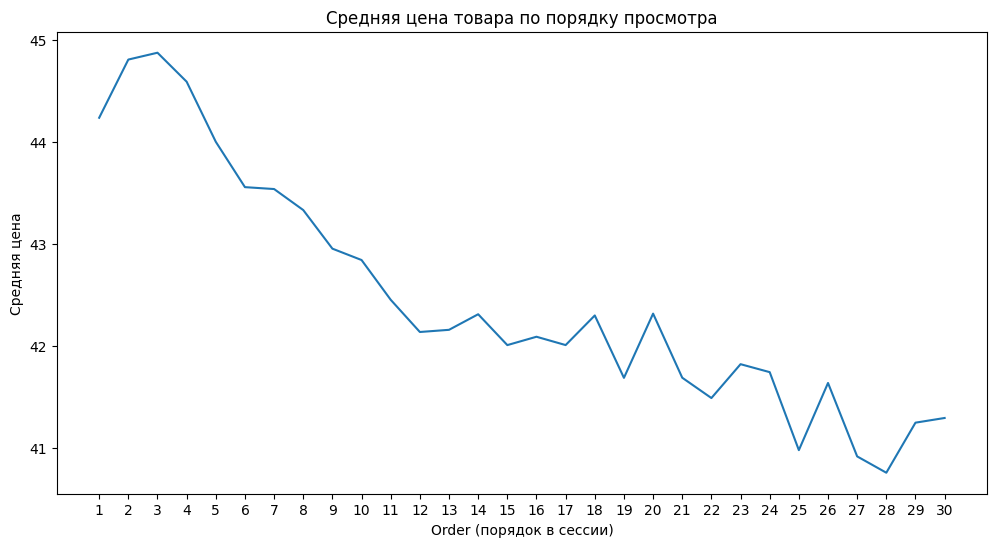

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(price_by_order['order'], price_by_order['mean_price'])
plt.xlabel('Order (порядок в сессии)')
plt.ylabel('Средняя цена')
plt.title('Средняя цена товара по порядку просмотра')
plt.xticks(price_by_order['order'])
plt.show()

#### Гипотеза 3: Средняя цена товара снижается с увеличением номера просмотра в сессии

Нулевая гипотеза: Средняя цена товара не зависит от порядка просмотра (нет тренда).

Альтернативная гипотеза: Средняя цена товара уменьшается с увеличением порядка просмотра (отрицательный тренд).

Для определения тренда будем использовать тест Спирмена. Условия для него: порядковые, интервальные или количественные данные, независимость наблюдений, наличие монотонности, достаточный размер выборки (n >= 30). Все условия выполняются (монотонность видно из графика).

In [ ]:
price_by_order = df.groupby('order')['price'].mean().reset_index(name='mean_price')

In [ ]:
from scipy.stats import spearmanr

print(spearmanr(df['order'], df['price']))

SignificanceResult(statistic=np.float64(-0.08453995039468154), pvalue=np.float64(7.473288831469281e-210))


В результате получаем p-value < 0.05 и отрицательный коэффициент корреляции, что говорит о том, что мы отклоняем нулевую гипотезу и считаем, что средняя цена товара снижается с увеличением номера просмотра в сессии.

In [ ]:
cat_by_order = (
    df_ord
    .groupby(['order', 'main_category'])
    .size()
    .reset_index(name='cnt')
)

/tmp/ipython-input-2267070709.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['order', 'main_category'])


In [ ]:
cat_by_order['share'] = (
    cat_by_order
    .groupby('order')['cnt']
    .transform(lambda x: x / x.sum())
)

cat_by_order

,order,main_category,cnt,share
0,1,blouses,3478,0.178735
1,1,sale,3619,0.185981
2,1,skirts,5466,0.280898
3,1,trousers,6896,0.354386
4,2,blouses,2981,0.191704
...,...,...,...,...
115,29,trousers,88,0.160878
116,30,blouses,120,0.237154
117,30,sale,235,0.464427
118,30,skirts,69,0.136364


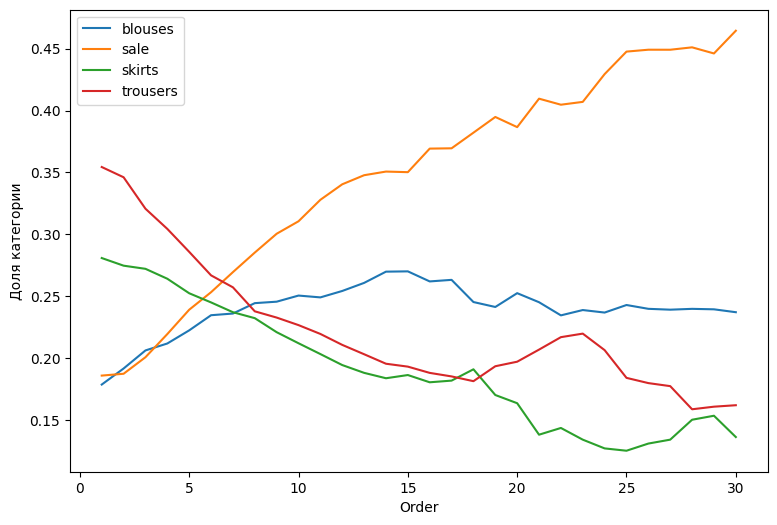

In [ ]:
plt.figure(figsize=(9, 6))

for cat in cat_by_order['main_category'].unique():
    tmp = cat_by_order[cat_by_order['main_category'] == cat]
    plt.plot(tmp['order'], tmp['share'], label=cat)

plt.xlabel('Order')
plt.ylabel('Доля категории')
plt.legend()
plt.show()

### Фото

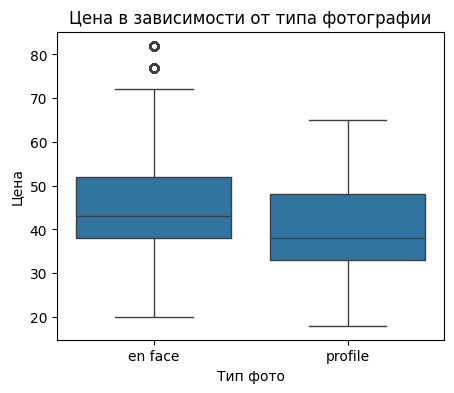

In [ ]:
plt.figure(figsize=(5, 4))
sns.boxplot(data=df,x="photo_type",y="price")
plt.title("Цена в зависимости от типа фотографии")
plt.xlabel("Тип фото")
plt.ylabel("Цена")
plt.show()

In [ ]:
clicks_by_type = df['photo_type'].value_counts().sort_index()
print(clicks_by_type)

photo_type
en face    97514
profile    35737
Name: count, dtype: int64


### Цвета

Среднее число кликов на товар каждого цвета

In [ ]:
clicks_by_colour = df.groupby('colour_name').size()
products_by_colour = df.groupby('colour_name')['clothing model'].nunique()

clicks_per_product = clicks_by_colour / products_by_colour

clicks_per_product_filtered = clicks_per_product[products_by_colour > 4].sort_values(ascending=False)

print(clicks_per_product_filtered)

colour_name
blue              1247.611111
beige              662.111111
green              580.200000
white              550.000000
violet             548.111111
brown              547.708333
black              546.511111
pink               536.000000
gray               526.037037
of many colors     511.772727
red                504.785714
dtype: float64


/tmp/ipython-input-3719397883.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  clicks_by_colour = df.groupby('colour_name').size()
/tmp/ipython-input-3719397883.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  products_by_colour = df.groupby('colour_name')['clothing model'].nunique()


Самый успешный с большим отрывом - blue, остальные значения существенно ближе друг к другу.

### Глубина сайта

Насколько далеко пользователи заходят на сайте

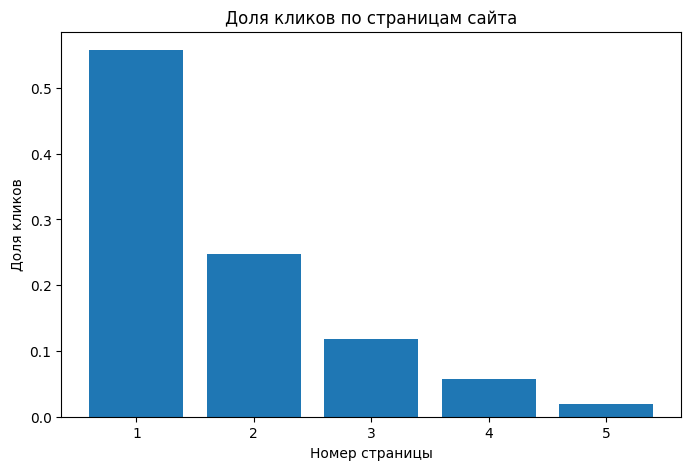

In [ ]:
clicks_by_page = (df.groupby('page').size().sort_index())

share_by_page = clicks_by_page / clicks_by_page.sum()

plt.figure(figsize=(8, 5))
plt.bar(share_by_page.index, share_by_page.values)
plt.xlabel('Номер страницы')
plt.ylabel('Доля кликов')
plt.title('Доля кликов по страницам сайта')
plt.show()

Средняя стоимость товара от глубины сайта

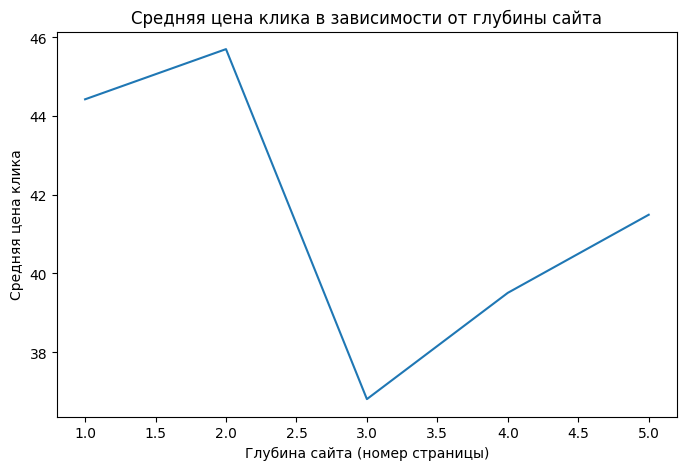

In [ ]:
avg_price_by_page = (df.groupby('page')['price'].mean())

plt.figure(figsize=(8, 5))
plt.plot(avg_price_by_page.index,avg_price_by_page.values,)
plt.xlabel('Глубина сайта (номер страницы)')
plt.ylabel('Средняя цена клика')
plt.title('Средняя цена клика в зависимости от глубины сайта')
plt.show()

## Выводы



Гипотеза 1: Зависимость категории товара от расположения карточки на странице

H₀: Распределение категорий товаров не зависит от расположения карточки на странице (top/bottom, left/middle/right)

H₁: Распределение категорий товаров зависит от расположения карточки

Если зависимость есть, магазин может оптимизировать размещение определённых категорий для увеличения кликов

---
Гипотеза 2: Влияние типа фотографии на цену просматриваемого товара


H₀:Средняя цена товаров, просматриваемых с фото "en face", равна средней цене товаров с фото "profile"

H₁:Средние цены различаются в зависимости от типа фотографии

Если тип фото влияет на то, какие товары просматривают, можно адаптировать фотоконтент под ценовой сегмент

---
Гипотеза 3: Различия в активности пользователей по дням недели

H₀: Количество кликов на сессию одинаково во все дни недели

H₁: Активность пользователей (клики на сессию) различается в зависимости от дня недели

Понимание пиковых дней позволит планировать промо-акции и управлять нагрузкой
